For mouse1: Correlation for First Phase: -4.12e-01 with a p-value: 1.07e-09
For mouse1: Correlation for Second Phase: -1.71e-01 with a p-value: 2.85e-07
For mouse1: Difference in correlations p-value: 0.000713776204281702
For mouse2: Correlation for First Phase: -2.69e-01 with a p-value: 4.85e-03
For mouse2: Correlation for Second Phase: -5.65e-02 with a p-value: 1.82e-01
For mouse2: Difference in correlations p-value: 0.03957179842065739
For mouse3: Correlation for First Phase: -4.06e-01 with a p-value: 8.15e-10
For mouse3: Correlation for Second Phase: 3.15e-02 with a p-value: 3.13e-01
For mouse3: Difference in correlations p-value: 1.5080359183627934e-09
For mouse4: Correlation for First Phase: -5.13e-01 with a p-value: 1.78e-15
For mouse4: Correlation for Second Phase: -8.32e-02 with a p-value: 5.74e-02
For mouse4: Difference in correlations p-value: 6.333725099949561e-09
For mouse5: Correlation for First Phase: -2.72e-01 with a p-value: 3.50e-04
For mouse5: Correlation for Second 

/var/folders/b1/18y84q5j7xg_hmnnzfyc1rnw0000gn/T/ipykernel_23432/2353960263.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


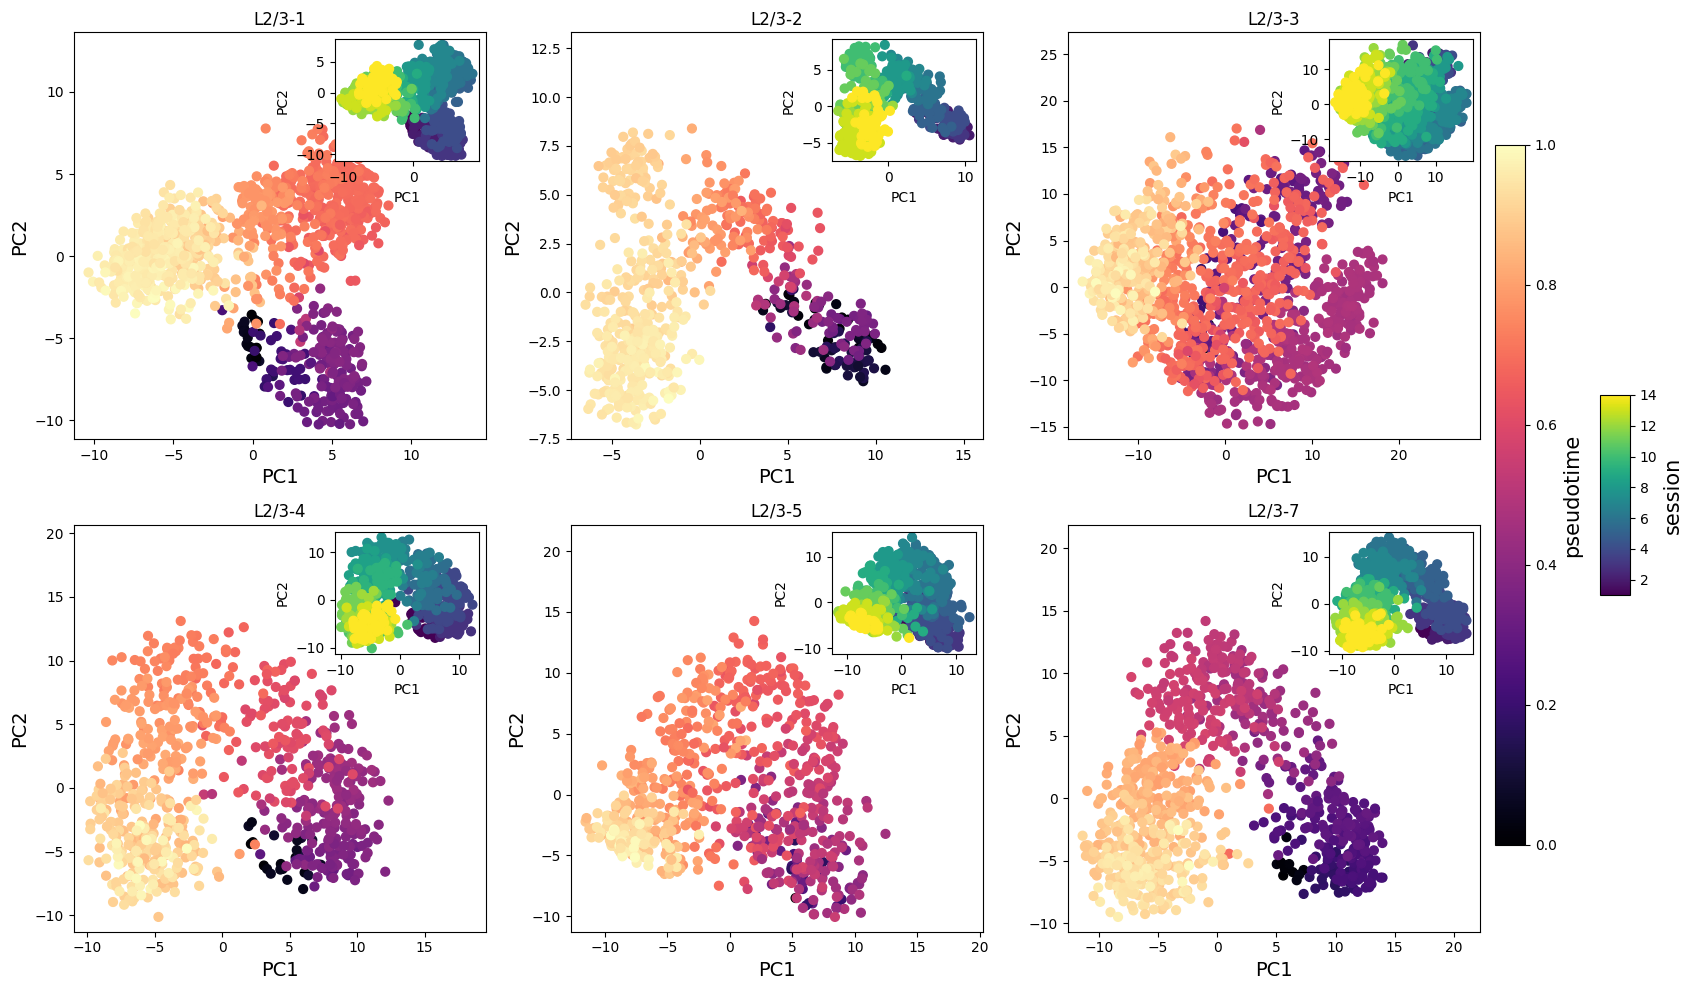

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits.axes_grid1.inset_locator as mpl_il
from scipy.stats import t

#Perform pseudotime analysis and evaluate correlations

#Set run parameters
layer = 'L23'
group1 = [1, 2, 3, 4] #First sessions definition
corrdf = pd.DataFrame(index=['First', 'Second', 'p-value'])

# Create a list to store the scatter plot objects for each mouse
sc_plots = []

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, mouse in enumerate(['mouse1', 'mouse2', 'mouse3', 'mouse4', 'mouse5', 'mouse7']):

    # Read the data from Excel file
    datafile = layer+'/'+mouse+'.xlsx'
    df = pd.read_excel(datafile)

    # Extract data columns
    row_labels = df.iloc[:, 0]
    pc_data = df.iloc[:, 2:]  # Exclude the second column (rewardTime)
    pc12_data = df.iloc[:, 2:4] #Only PC1 and PC2

    # Create AnnData object
    adata = sc.AnnData(X=pc_data.values)
    adata.obs['session'] = row_labels.values
    adata.var_names = pc_data.columns.values

    # Create separate DataFrame for rewardTime
    reward_time = df.iloc[:, 1]
    reward_time_df = pd.DataFrame({'rewardTime': reward_time})

    # Add rewardTime as a separate DataFrame to AnnData object
    adata.obs['reward_time'] = reward_time_df.values

    # Add pc1+pc2 as a separate DataFrame to AnnData object
    adata.obsm['X_pca'] = pc12_data.values

    ## Pseudotime analysis

    #Get network embedding
    sc.pp.neighbors(adata, use_rep='X')

    #Assign root
    adata.uns['iroot'] = 0

    # Run diffusion pseudotime (DPT) analysis
    sc.tl.diffmap(adata)
    sc.tl.dpt(adata)

    ##Compute Correlations
    # Create a boolean mask for early sessions (group 1) and late sessions (group 2)
    group_1_mask = adata.obs['session'].isin(group1)
    group_2_mask = ~group_1_mask

    # Filter 'reward_time' and 'dpt_pseudotime' using the group masks
    group_1_reward_time = adata.obs['reward_time'][group_1_mask]
    group_1_dpt_pseudotime = adata.obs['dpt_pseudotime'][group_1_mask]

    group_2_reward_time = adata.obs['reward_time'][group_2_mask]
    group_2_dpt_pseudotime = adata.obs['dpt_pseudotime'][group_2_mask]

    # Compute correlations
    corr_group_1 = np.corrcoef(group_1_reward_time, group_1_dpt_pseudotime)[0, 1]
    corr_group_2 = np.corrcoef(group_2_reward_time, group_2_dpt_pseudotime)[0, 1]

    ## Evaluate statistical significance
    # Sample sizes
    n_group_1 = len(group_1_reward_time)
    n_group_2 = len(group_2_reward_time)

    # Standard errors
    se_group_1 = np.sqrt((1 - corr_group_1 ** 2) / (n_group_1 - 2))
    se_group_2 = np.sqrt((1 - corr_group_2 ** 2) / (n_group_2 - 2))

    # t-statistics
    t_group_1 = corr_group_1 / se_group_1
    t_group_2 = corr_group_2 / se_group_2

    # p-values
    p_value_group_1 = 2 * (1 - t.cdf(np.abs(t_group_1), n_group_1 - 2))
    p_value_group_2 = 2 * (1 - t.cdf(np.abs(t_group_2), n_group_2 - 2))

    print("For "+mouse+": Correlation for First Phase: {:.2e} with a p-value: {:.2e}".format(corr_group_1, p_value_group_1))
    print("For "+mouse+": Correlation for Second Phase: {:.2e} with a p-value: {:.2e}".format(corr_group_2, p_value_group_2))

    #Statistical test for correlation difference
    # Fisher's z-transform
    z_group_1 = 0.5 * np.log((1 + corr_group_1) / (1 - corr_group_1))
    z_group_2 = 0.5 * np.log((1 + corr_group_2) / (1 - corr_group_2))

    # Standard errors for z-transformed correlations
    se_group_1 = 1 / np.sqrt(n_group_1 - 3)
    se_group_2 = 1 / np.sqrt(n_group_2 - 3)

    # Standard error of the difference
    se_diff = np.sqrt(se_group_1**2 + se_group_2**2)

    # Test statistic
    t_diff = (z_group_1 - z_group_2) / se_diff

    # Degrees of freedom
    df_diff = n_group_1 + n_group_2 - 4

    # Two-tailed p-value
    p_value_diff = 2 * (1 - t.cdf(np.abs(t_diff), df_diff))

    print("For "+mouse+": Difference in correlations p-value:", p_value_diff)
    
    temp_df = pd.DataFrame({mouse: [corr_group_1, corr_group_2, p_value_diff]}, index=['First', 'Second', 'p-value'])
    corrdf = pd.concat([corrdf, temp_df], axis=1)

    # Specify the subplot for the current mouse
    ax = axs.flatten()[i]
    plt.sca(ax)

    # Scatter plot of PC1 vs PC2 with dpt_pseudotime as color
    sc_plot = ax.scatter(adata.obsm['X_pca'][:, 0], adata.obsm['X_pca'][:, 1], c=adata.obs['dpt_pseudotime'], cmap='magma', s=40)
    ax.set_xlabel('PC1', fontsize=14)
    ax.set_ylabel('PC2', fontsize=14)
    ax.set_title('L2/3-' + mouse[-1:])

    # Adjust x and y axis limits
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    x_range = x_max - x_min
    y_range = y_max - y_min
    ax.set_xlim(x_min, x_max + 0.25 * x_range)
    ax.set_ylim(y_min, y_max + 0.25 * y_range)

    # Add inset figure
    ax_inset = mpl_il.inset_axes(ax, width='35%', height='30%', loc='upper right')
    inset_sc_plot = ax_inset.scatter(adata.obsm['X_pca'][:, 0], adata.obsm['X_pca'][:, 1], c=adata.obs['session'], cmap='viridis', s=40)
    ax_inset.set_xlabel('PC1', fontsize=10)
    ax_inset.set_ylabel('PC2', fontsize=10)

    # Store the scatter plot object in the list
    sc_plots.append(sc_plot)

# Create a single color bar for the main figure (dpt_pseudotime)
cbar_main_ax = fig.add_axes([1.00, 0.15, 0.02, 0.7])
cbar_main = fig.colorbar(sc_plots[0], cax=cbar_main_ax)
cbar_main.set_label('pseudotime', size=15)

# Create a single color bar for the inset figures (session)
cbar_inset_ax = fig.add_axes([1.07, 0.4, 0.02, 0.2])
cbar_inset = fig.colorbar(inset_sc_plot, cax=cbar_inset_ax)
cbar_inset.set_label('session', size=15)

# Adjust spacing between subplots
plt.tight_layout()

#save
figfile = 'figures/'+layer+'-dpt'
fig.savefig(figfile, dpi=300, bbox_inches='tight')

plt.show()

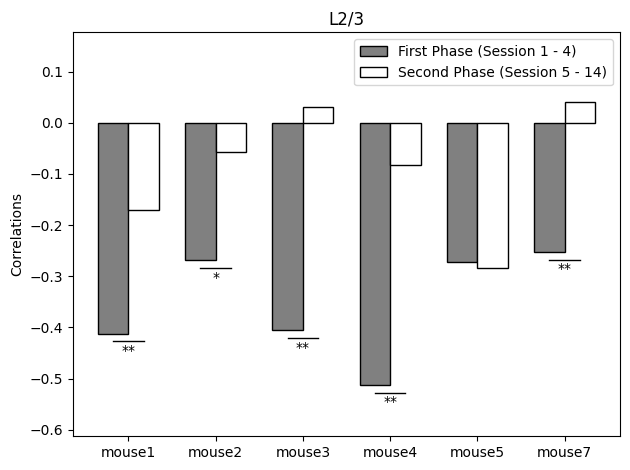

In [3]:
import matplotlib.patches as mpatches

#Plot results of correlation analysis
# Set up the figure and axis
fig, ax = plt.subplots()

# Calculate the width for each bar
num_columns = corrdf.shape[1]
bar_width = 0.35

# Set the positions of the bars on the x-axis
index = np.arange(num_columns)

# Plot the bars
rects1 = ax.bar(index, corrdf.iloc[0], bar_width, color='gray', edgecolor='black', linewidth=1, label='First')
rects2 = ax.bar(index + bar_width, corrdf.iloc[1], bar_width, color='white', edgecolor='black', linewidth=1, label='Second')

for i, val in enumerate(corrdf.iloc[2]):
    if 0.01 < val <= 0.05:
        if corrdf.iloc[0, i] > 0:  # If the value in the first row is positive
            ax.text(index[i] + bar_width / 2, max(corrdf.iloc[0, i], corrdf.iloc[1, i]) + 0.02, '*', ha='center', va='bottom')
            center_x = index[i] + bar_width / 2
            center_y = max(corrdf.iloc[0, i], corrdf.iloc[1, i]) + 0.015
            ax.plot([center_x - bar_width / 2, center_x + bar_width / 2], [center_y, center_y], color='black', linewidth=1)
        else:  # If the value in the first row is negative
            ax.text(index[i] + bar_width / 2, min(corrdf.iloc[0, i], corrdf.iloc[1, i]) - 0.02, '*', ha='center', va='top')
            center_x = index[i] + bar_width / 2
            center_y = min(corrdf.iloc[0, i], corrdf.iloc[1, i]) - 0.015
            ax.plot([center_x - bar_width / 2, center_x + bar_width / 2], [center_y, center_y], color='black', linewidth=1)
    elif val <= 0.01:
        if corrdf.iloc[0, i] > 0:  # If the value in the first row is positive
            ax.text(index[i] + bar_width / 2, max(corrdf.iloc[0, i], corrdf.iloc[1, i]) + 0.02, '**', ha='center', va='bottom')
            center_x = index[i] + bar_width / 2
            center_y = max(corrdf.iloc[0, i], corrdf.iloc[1, i]) + 0.015
            ax.plot([center_x - bar_width / 2, center_x + bar_width / 2], [center_y, center_y], color='black', linewidth=1)
        else:  # If the value in the first row is negative
            ax.text(index[i] + bar_width / 2, min(corrdf.iloc[0, i], corrdf.iloc[1, i]) - 0.02, '**', ha='center', va='top')
            center_x = index[i] + bar_width / 2
            center_y = min(corrdf.iloc[0, i], corrdf.iloc[1, i]) - 0.015
            ax.plot([center_x - bar_width / 2, center_x + bar_width / 2], [center_y, center_y], color='black', linewidth=1)

        
# Customize the plot
ax.set_ylabel('Correlations')
ax.set_title('L2/3')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(corrdf.columns)

# Create legend handles with patches matching the bar colors
early_patch = mpatches.Patch(facecolor='gray', edgecolor='black', linewidth=1, label='First Phase (Session '+str(min(group1))+' - '+str(max(group1))+')')
later_patch = mpatches.Patch(facecolor='white', edgecolor='black', linewidth=1, label='Second Phase (Session '+str(max(group1)+1)+' - '+str(row_labels.max())+')')

# Create the legend using the patches
ax.legend(handles=[early_patch, later_patch])

# Adjust y-axis limits
y_min = min(corrdf.min()) - 0.1
y_max = max(corrdf.max()) - 0.7
ax.set_ylim([y_min, y_max])

# Save the output to file at 300 dpi
plt.tight_layout()
plt.savefig('figures/'+layer+'_corr.png', dpi=300)

# Display the plot
plt.show()

For mouse1: Correlation for First Phase: -2.30e-02 with a p-value: 6.55e-01
For mouse1: Correlation for Second Phase: 1.01e-01 with a p-value: 1.50e-03
For mouse1: Difference in correlations p-value: 0.04066294456053465
For mouse2: Correlation for First Phase: 7.86e-02 with a p-value: 1.38e-01
For mouse2: Correlation for Second Phase: -1.04e-02 with a p-value: 6.95e-01
For mouse2: Difference in correlations p-value: 0.13392548620382105
For mouse3: Correlation for First Phase: -4.24e-01 with a p-value: 0.00e+00
For mouse3: Correlation for Second Phase: -2.60e-01 with a p-value: 0.00e+00
For mouse3: Difference in correlations p-value: 0.0015472842263768438
For mouse4: Correlation for First Phase: 2.40e-01 with a p-value: 1.01e-06
For mouse4: Correlation for Second Phase: -5.42e-02 with a p-value: 7.65e-02
For mouse4: Difference in correlations p-value: 3.6443458095725134e-07
For mouse5: Correlation for First Phase: -2.48e-01 with a p-value: 2.40e-06
For mouse5: Correlation for Second Pha

/var/folders/b1/18y84q5j7xg_hmnnzfyc1rnw0000gn/T/ipykernel_23432/3240654334.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


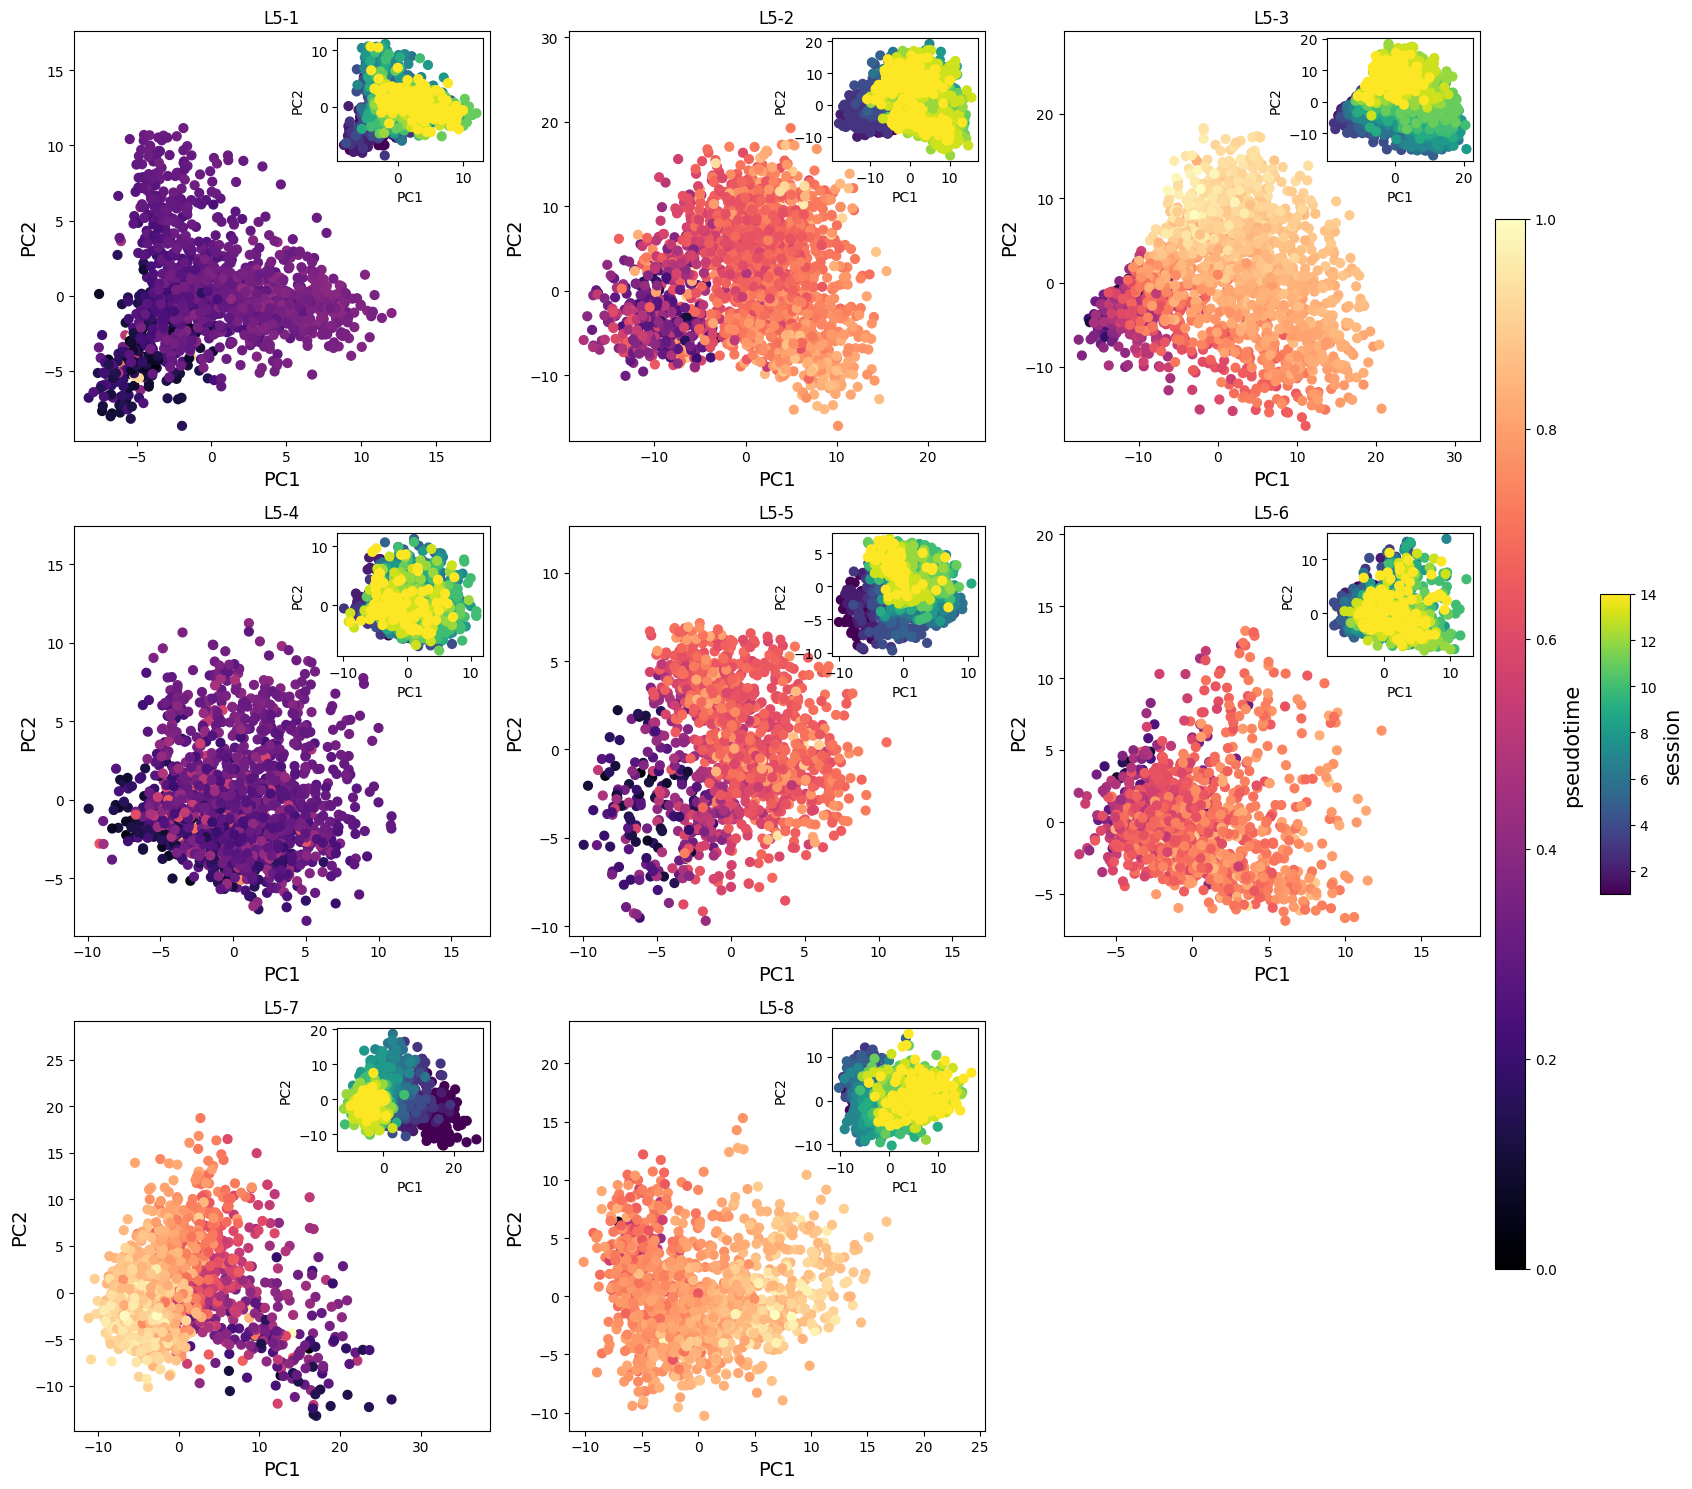

In [4]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits.axes_grid1.inset_locator as mpl_il
from scipy.stats import t

#Set run parameters
layer = 'L5'
group1 = [1, 2, 3, 4] #Early sessions definition
corrdf = pd.DataFrame(index=['First', 'Second', 'p-value'])

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Create a list to store the scatter plot objects for each mouse
sc_plots = []

for i, mouse in enumerate(['mouse1', 'mouse2', 'mouse3', 'mouse4', 'mouse5', 'mouse6', 'mouse7', 'mouse8']):
    # Read the data from Excel file
    datafile = layer+'/'+mouse+'.xlsx'
    df = pd.read_excel(datafile)

    # Extract data columns
    row_labels = df.iloc[:, 0]
    pc_data = df.iloc[:, 2:]  # Exclude the second column (rewardTime)
    pc12_data = df.iloc[:, 2:4] #Only PC1 and PC2

    # Create AnnData object
    adata = sc.AnnData(X=pc_data.values)
    adata.obs['session'] = row_labels.values
    adata.var_names = pc_data.columns.values

    # Create separate DataFrame for rewardTime
    reward_time = df.iloc[:, 1]
    reward_time_df = pd.DataFrame({'rewardTime': reward_time})

    # Add rewardTime as a separate DataFrame to AnnData object
    adata.obs['reward_time'] = reward_time_df.values

    # Add pc1+pc2 as a separate DataFrame to AnnData object
    adata.obsm['X_pca'] = pc12_data.values

    ## Pseudotime analysis

    #Get network embedding
    sc.pp.neighbors(adata, use_rep='X')

    #Assign root
    adata.uns['iroot'] = 0

    # Run diffusion pseudotime (DPT) analysis
    sc.tl.diffmap(adata)
    sc.tl.dpt(adata)

    ##Compute Correlations
    # Create a boolean mask for early sessions (group 1) and late sessions (group 2)
    group_1_mask = adata.obs['session'].isin(group1)
    group_2_mask = ~group_1_mask

    # Filter 'reward_time' and 'dpt_pseudotime' using the group masks
    group_1_reward_time = adata.obs['reward_time'][group_1_mask]
    group_1_dpt_pseudotime = adata.obs['dpt_pseudotime'][group_1_mask]

    group_2_reward_time = adata.obs['reward_time'][group_2_mask]
    group_2_dpt_pseudotime = adata.obs['dpt_pseudotime'][group_2_mask]

    # Compute correlations
    corr_group_1 = np.corrcoef(group_1_reward_time, group_1_dpt_pseudotime)[0, 1]
    corr_group_2 = np.corrcoef(group_2_reward_time, group_2_dpt_pseudotime)[0, 1]

    ## Evaluate statistical significance
    # Sample sizes
    n_group_1 = len(group_1_reward_time)
    n_group_2 = len(group_2_reward_time)

    # Standard errors
    se_group_1 = np.sqrt((1 - corr_group_1 ** 2) / (n_group_1 - 2))
    se_group_2 = np.sqrt((1 - corr_group_2 ** 2) / (n_group_2 - 2))

    # t-statistics
    t_group_1 = corr_group_1 / se_group_1
    t_group_2 = corr_group_2 / se_group_2

    # p-values
    p_value_group_1 = 2 * (1 - t.cdf(np.abs(t_group_1), n_group_1 - 2))
    p_value_group_2 = 2 * (1 - t.cdf(np.abs(t_group_2), n_group_2 - 2))

    print("For "+mouse+": Correlation for First Phase: {:.2e} with a p-value: {:.2e}".format(corr_group_1, p_value_group_1))
    print("For "+mouse+": Correlation for Second Phase: {:.2e} with a p-value: {:.2e}".format(corr_group_2, p_value_group_2))

    #Statistical test for correlation difference
    # Fisher's z-transform
    z_group_1 = 0.5 * np.log((1 + corr_group_1) / (1 - corr_group_1))
    z_group_2 = 0.5 * np.log((1 + corr_group_2) / (1 - corr_group_2))

    # Standard errors for z-transformed correlations
    se_group_1 = 1 / np.sqrt(n_group_1 - 3)
    se_group_2 = 1 / np.sqrt(n_group_2 - 3)

    # Standard error of the difference
    se_diff = np.sqrt(se_group_1**2 + se_group_2**2)

    # Test statistic
    t_diff = (z_group_1 - z_group_2) / se_diff

    # Degrees of freedom
    df_diff = n_group_1 + n_group_2 - 4

    # Two-tailed p-value
    p_value_diff = 2 * (1 - t.cdf(np.abs(t_diff), df_diff))

    print("For "+mouse+": Difference in correlations p-value:", p_value_diff)
    
    temp_df = pd.DataFrame({mouse: [corr_group_1, corr_group_2, p_value_diff]}, index=['First', 'Second', 'p-value'])
    corrdf = pd.concat([corrdf, temp_df], axis=1)

    # Specify the subplot for the current mouse
    ax = axs.flatten()[i]
    plt.sca(ax)

    # Scatter plot of PC1 vs PC2 with dpt_pseudotime as color
    sc_plot = ax.scatter(adata.obsm['X_pca'][:, 0], adata.obsm['X_pca'][:, 1], c=adata.obs['dpt_pseudotime'], cmap='magma', s=40)
    ax.set_xlabel('PC1', fontsize=14)
    ax.set_ylabel('PC2', fontsize=14)
    ax.set_title('L5-' + mouse[-1:])

    # Adjust x and y axis limits
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    x_range = x_max - x_min
    y_range = y_max - y_min
    ax.set_xlim(x_min, x_max + 0.25 * x_range)
    ax.set_ylim(y_min, y_max + 0.25 * y_range)

    # Add inset figure
    ax_inset = mpl_il.inset_axes(ax, width='35%', height='30%', loc='upper right')
    inset_sc_plot = ax_inset.scatter(adata.obsm['X_pca'][:, 0], adata.obsm['X_pca'][:, 1], c=adata.obs['session'], cmap='viridis', s=40)
    ax_inset.set_xlabel('PC1', fontsize=10)
    ax_inset.set_ylabel('PC2', fontsize=10)

    # Store the scatter plot object in the list
    sc_plots.append(sc_plot)

# Remove the axis of the last subfigure
axs.flatten()[-1].axis('off')

# Create a single color bar for the main figure (dpt_pseudotime)
cbar_main_ax = fig.add_axes([1.00, 0.15, 0.02, 0.7])
cbar_main = fig.colorbar(sc_plots[0], cax=cbar_main_ax)
cbar_main.set_label('pseudotime', size=15)

# Create a single color bar for the inset figures (session)
cbar_inset_ax = fig.add_axes([1.07, 0.4, 0.02, 0.2])
cbar_inset = fig.colorbar(inset_sc_plot, cax=cbar_inset_ax)
cbar_inset.set_label('session', size=15)


# Adjust spacing between subplots
plt.tight_layout()

#save
figfile = 'figures/'+layer+'-dpt'
fig.savefig(figfile, dpi=300, bbox_inches='tight')

plt.show()

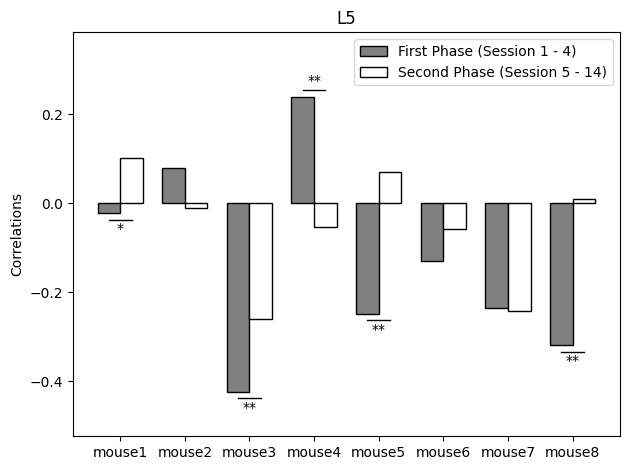

In [5]:
import matplotlib.patches as mpatches

# Set up the figure and axis
fig, ax = plt.subplots()

# Calculate the width for each bar
num_columns = corrdf.shape[1]
bar_width = 0.35

# Set the positions of the bars on the x-axis
index = np.arange(num_columns)

# Plot the bars
rects1 = ax.bar(index, corrdf.iloc[0], bar_width, color='gray', edgecolor='black', linewidth=1, label='Early')
rects2 = ax.bar(index + bar_width, corrdf.iloc[1], bar_width, color='white', edgecolor='black', linewidth=1, label='Later')

for i, val in enumerate(corrdf.iloc[2]):
    if 0.01 < val <= 0.05:
        if corrdf.iloc[0, i] > 0:  # If the value in the first row is positive
            ax.text(index[i] + bar_width / 2, max(corrdf.iloc[0, i], corrdf.iloc[1, i]) + 0.02, '*', ha='center', va='bottom')
            center_x = index[i] + bar_width / 2
            center_y = max(corrdf.iloc[0, i], corrdf.iloc[1, i]) + 0.015
            ax.plot([center_x - bar_width / 2, center_x + bar_width / 2], [center_y, center_y], color='black', linewidth=1)
        else:  # If the value in the first row is negative
            ax.text(index[i] + bar_width / 2, min(corrdf.iloc[0, i], corrdf.iloc[1, i]) - 0.02, '*', ha='center', va='top')
            center_x = index[i] + bar_width / 2
            center_y = min(corrdf.iloc[0, i], corrdf.iloc[1, i]) - 0.015
            ax.plot([center_x - bar_width / 2, center_x + bar_width / 2], [center_y, center_y], color='black', linewidth=1)
    elif val <= 0.01:
        if corrdf.iloc[0, i] > 0:  # If the value in the first row is positive
            ax.text(index[i] + bar_width / 2, max(corrdf.iloc[0, i], corrdf.iloc[1, i]) + 0.02, '**', ha='center', va='bottom')
            center_x = index[i] + bar_width / 2
            center_y = max(corrdf.iloc[0, i], corrdf.iloc[1, i]) + 0.015
            ax.plot([center_x - bar_width / 2, center_x + bar_width / 2], [center_y, center_y], color='black', linewidth=1)
        else:  # If the value in the first row is negative
            ax.text(index[i] + bar_width / 2, min(corrdf.iloc[0, i], corrdf.iloc[1, i]) - 0.02, '**', ha='center', va='top')
            center_x = index[i] + bar_width / 2
            center_y = min(corrdf.iloc[0, i], corrdf.iloc[1, i]) - 0.015
            ax.plot([center_x - bar_width / 2, center_x + bar_width / 2], [center_y, center_y], color='black', linewidth=1)

# Customize the plot
ax.set_ylabel('Correlations')
ax.set_title('L5')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(corrdf.columns)

# Create legend handles with patches matching the bar colors
early_patch = mpatches.Patch(facecolor='gray', edgecolor='black', linewidth=1, label='First Phase (Session '+str(min(group1))+' - '+str(max(group1))+')')
later_patch = mpatches.Patch(facecolor='white', edgecolor='black', linewidth=1, label='Second Phase (Session '+str(max(group1)+1)+' - '+str(row_labels.max())+')')

# Create the legend using the patches
ax.legend(handles=[early_patch, later_patch])

# Adjust y-axis limits
y_min = min(corrdf.min()) - 0.1
y_max = max(corrdf.max()) - 0.5
ax.set_ylim([y_min, y_max])

# Save the output to file at 300 dpi
plt.tight_layout()
plt.savefig('figures/'+layer+'_corr.png', dpi=300)

# Display the plot
plt.show()